# Contents:
- [1. Import Libraries & Data](#import-libraries)
- [2. Data Preprocessing](#data-preprocessing)
- [3. Models Experiments](#models)
    - [3.1 All Features](#All-Features)
    - [3.2 Feature-Selection](#Feature-Selection)
    - [3.3 Feature Selection using PCA](#Feature-Selection-PCA)
- [4. Hyperparameter Tuning](#Hyperparameter-Tuning)
- [5. ANN](#ann)

<a id="import-libraries"></a>
# 1. Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#warnings.filterwarnings('ignore')

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models 
from sklearn.linear_model import LinearRegression
from sklearn. linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [3]:
data = pd.read_csv('../../data/processed/trial4.csv')

In [4]:
data.head(2)

,logkpl,Texpi,ALogP,ALogp2,AMR,apol,nAcid,naAromAtom,nAromBond,nAtom,...,MW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,-2.25,298,1.4570,2.122849,35.0768,17.399965,0,6,6,15,...,139.109037,19.385708,1.938571,10.344796,7.326862,3.017933,120.0,11.0,1.508,46.0
1,-2.95,310,3.6304,13.179804,49.4776,32.539860,1,0,0,32,...,172.264984,22.661828,1.888486,4.763098,4.763098,0.000000,277.0,9.0,4.156,44.0


In [5]:
data.shape

(450, 224)

In [6]:
# no missing values
data.isna().sum().sum()

0

<a id="data-preprocessing"></a>
# 2. Data Preprocessing

In [110]:
model_data = data.copy()

In [111]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)

print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

Shape of X_train: (337, 223) 	 Shape of y_train: (337,)
Shape of X_test: (113, 223) 	 Shape of y_test: (113,)


<a id="models"></a>
# 3. Models Experiments

In [112]:
def plot_feature_importance(model, cols, model_name, slice=20):
    importances = model.feature_importances_
    feature_names = cols#X.columns#selected_features_X.columns #

    # Create a pandas DataFrame with the feature importances
    df = pd.DataFrame({"feature": feature_names, "importance": importances})

    # Sort the DataFrame by importance score
    df = df.sort_values("importance", ascending=False).reset_index(drop=True)

    # Create a bar plot using Seaborn
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.barplot(x="importance", y="feature", data=df[:slice])
    plt.title("Top 20 Feature Importances {}".format(model_name))
    plt.ylabel("Feature Name")
    plt.xlabel("Importance")
    plt.show()

<a id="All-Features"></a>
### 3.1 All Features

In [113]:
def evaluate_model(model_df, i, model_name, model, X, y, X_test, y_test):
    """
    this function is for regression takes the model with the data and calculate
    the scores, with cross validation techniques, in addition to MAE, MSE, RMSE, MAPE
    R Squared and Adjusted R Squared

    :param model: model
    :param X_train, X_test, y_train, y_test: data that was used
    """

    # cross validation with 5 folds
    all_cv_5 = cross_val_score(model, X, y, cv=5, scoring="r2")
    print("all CV 5: {}".format(all_cv_5))
    # print("Mean Cross-Validation score: {}".format(all_cv_5.mean()))

    # predictions from our model
    predictions = model.predict(X_test)


    # calculating R squared and Adjusted R squared
    r_sqre = r2_score(y_test, predictions)
    n = len(y_test)
    p = X_test.shape[1] # number of independant features

    Adj_r2 = 1 - ((1 - r_sqre) * (n - 1) / (n - 1 - p))
    
    test_mae = mean_absolute_error(y_test, predictions)

    test_mse = mean_squared_error(y_test, predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

    


    print("=" * 40)
    model_df.loc[i] = [model_name, all_cv_5.mean(),
                    test_mae, mean_absolute_percentage_error(y_test, predictions),
                   test_mse, test_rmse, r_sqre, Adj_r2]

    return model_df

In [114]:
# Building pipelins of standard scaler and model for varios regressors.

lasso = Lasso()

dt = DecisionTreeRegressor()

rf = RandomForestRegressor()

kn = KNeighborsRegressor()

xgb = XGBRegressor()

gbr = GradientBoostingRegressor()

eln = ElasticNet()

br = BayesianRidge()

cat = CatBoostRegressor(allow_writing_files=False, verbose=0, task_type="GPU")

lgbm = LGBMRegressor()



# List of all the pipelines
pipelines = [lasso, dt, rf, kn, xgb, gbr,
            eln, br, cat, lgbm] # 

# Dictionary of pipelines and model types for ease of reference
ml_dict = {0: "Lasso", 1: "DecisionTree", 2: "RandomForest", 3: "KNeighbors", 4: "XGBRegressor", 5: "GradientBoostingRegressor",
                6: "Elastic Net", 7:"BayesianRidge", 8: "CatBoostRegressor", 9: "LGBMRegressor"}
    #, 

models_scores_df = pd.DataFrame(columns=["model", "Mean CV", "MAE",
                                         "MAPE", "MSE", "RMSE", "R_Squared", "Adjusted_R_Squared"])



# Fit the pipelines and display the scores with Cross validation
for i, pipe in enumerate(pipelines):
    # getting the name of our model
    model_name = ml_dict[i]
    print(model_name)
    
    # fitting our data
    pipe.fit(X_train, y_train)
    
    evaluate_model(models_scores_df, i, model_name, pipe, X, y, X_test, y_test)

Lasso


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e+00, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.813e-01, tolerance: 3.921e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [ 0.09596436 -0.31863139 -0.42651363  0.42078674  0.43065162]
DecisionTree
all CV 5: [0.19514351 0.25306367 0.5595003  0.19912363 0.66541399]
RandomForest
all CV 5: [0.49955946 0.52992754 0.34046922 0.49475465 0.79285111]
KNeighbors
all CV 5: [-0.32285391  0.00632638 -0.27547185 -0.35466869 -0.30458892]
XGBRegressor
all CV 5: [0.4042212  0.55011838 0.29568576 0.46748581 0.79835454]
GradientBoostingRegressor
all CV 5: [0.52179993 0.54265618 0.53053281 0.49585829 0.76918767]
Elastic Net
all CV 5: [ 0.16256169 -0.34842207 -0.4282144   0.37582757  0.47638209]
BayesianRidge


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.873e+00, tolerance: 4.524e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.355e+01, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [-0.06315232  0.01222434  0.48846638  0.36839012 -6.24521509]
CatBoostRegressor
all CV 5: [0.50141192 0.54149301 0.32609989 0.49679384 0.78073103]
LGBMRegressor
all CV 5: [0.44795495 0.49288561 0.31319208 0.34447916 0.81183031]


In [115]:
models_scores_df

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,Lasso,0.040452,0.990237,0.462098,1.373766,1.172078,-0.001266,2.010287
1,DecisionTree,0.374449,0.393334,0.169780,0.286553,0.535307,0.791146,1.210735
2,RandomForest,0.531512,0.414405,0.175025,0.300212,0.547916,0.781191,1.220780
3,KNeighbors,-0.250251,0.451947,0.190148,0.382305,0.618308,0.721358,1.281153
4,XGBRegressor,0.503173,0.401310,0.171236,0.310763,0.557461,0.773501,1.228539
5,GradientBoostingRegressor,0.572007,0.391872,0.163565,0.272531,0.522045,0.801367,1.200423
6,Elastic Net,0.047627,0.911833,0.426850,1.169914,1.081626,0.147311,1.860371
7,BayesianRidge,-1.087857,0.467131,0.205746,0.394315,0.627945,0.712604,1.289985
8,CatBoostRegressor,0.529306,0.387683,0.162174,0.269895,0.519514,0.803288,1.198485
9,LGBMRegressor,0.482068,0.396571,0.166144,0.287991,0.536648,0.790098,1.211793


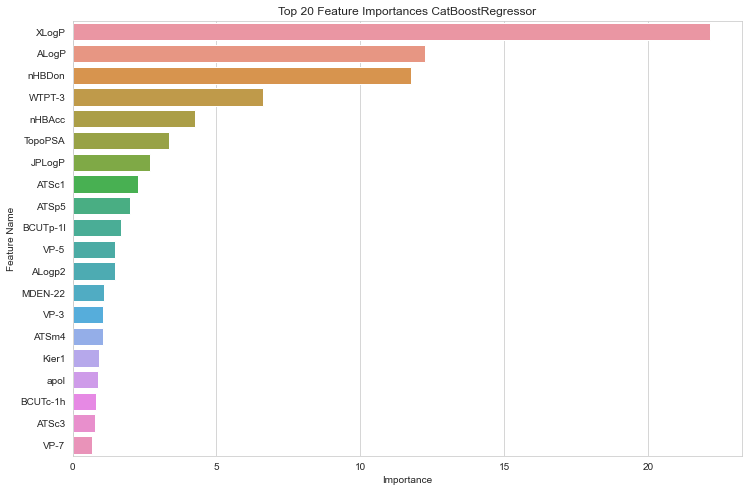

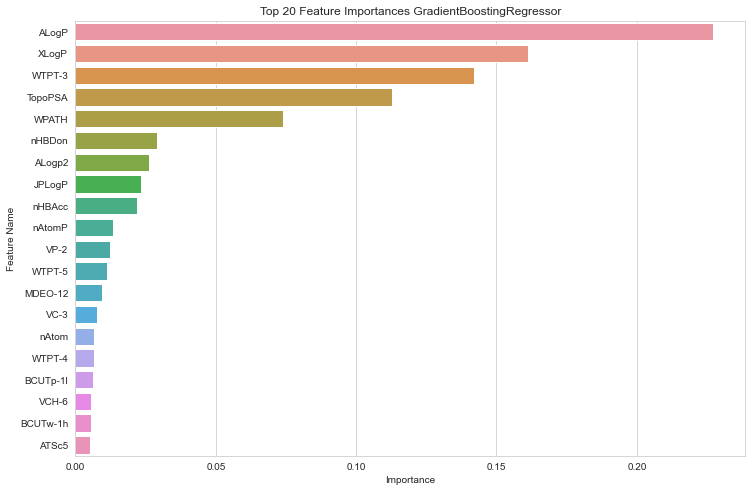

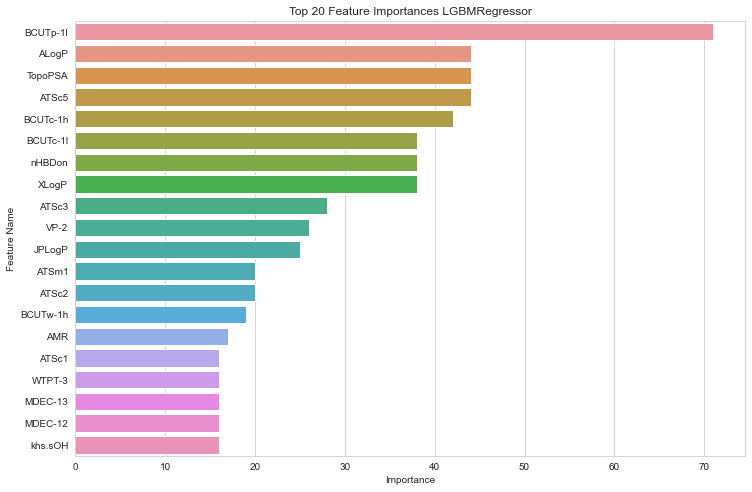

In [116]:
metric = "MAPE"

# selecting top 3 score based on metric
filtered_models_scores_df =  models_scores_df.sort_values(metric).iloc[:3, :]

for i in filtered_models_scores_df.index:
    plot_feature_importance(pipelines[i],  X.columns, ml_dict[i])

<a id="Feature-Selection"></a>
### 3.2 Feature Selection

In [121]:
import statsmodels.api as sm
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [122]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(XGBRegressor(), 
           k_features=15,
           forward=True, 
           floating=False, 
           verbose=2,
           scoring="neg_mean_absolute_percentage_error",
           cv=0)

sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 223 out of 223 | elapsed:    5.1s finished

[2023-03-18 20:36:15] Features: 1/15 -- score: -0.11118205393982504[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 222 out of 222 | elapsed:    7.0s finished

[2023-03-18 20:36:22] Features: 2/15 -- score: -0.10709200897484661[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 221 out of 221 | elapsed:    7.7s finished

[2023-03-18 20:36:30] Features: 3/15 -- score: -0.10681920429661185[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: 

In [123]:
# try selecting more features
sfs1.k_feature_names_

('ATSc2',
 'ATSp1',
 'BCUTp-1l',
 'C2SP1',
 'C3SP3',
 'C4SP3',
 'fragC',
 'khs.sLi',
 'khs.ssBe',
 'khs.ssssBe',
 'khs.ssBH',
 'khs.sssB',
 'khs.ssssB',
 'khs.tCH',
 'khs.sNH3')

In [124]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(19,)",[-0.11118205393982504],-0.111182,"(ATSp1,)",NaN,0.0,NaN
2,"(10, 19)",[-0.10709200897484661],-0.107092,"(ATSc2, ATSp1)",NaN,0.0,NaN
3,"(10, 19, 28)",[-0.10681920429661185],-0.106819,"(ATSc2, ATSp1, BCUTp-1l)",NaN,0.0,NaN
4,"(10, 19, 28, 40)",[-0.10680104459321466],-0.106801,"(ATSc2, ATSp1, BCUTp-1l, C3SP3)",NaN,0.0,NaN
5,"(10, 19, 28, 40, 85)",[-0.10678969340798529],-0.10679,"(ATSc2, ATSp1, BCUTp-1l, C3SP3, fragC)",NaN,0.0,NaN
6,"(10, 19, 28, 34, 40, 85)",[-0.10678969340798529],-0.10679,"(ATSc2, ATSp1, BCUTp-1l, C2SP1, C3SP3, fragC)",NaN,0.0,NaN
7,"(10, 19, 28, 34, 40, 41, 85)",[-0.10678969340798529],-0.10679,"(ATSc2, ATSp1, BCUTp-1l, C2SP1, C3SP3, C4SP3, ...",NaN,0.0,NaN
8,"(10, 19, 28, 34, 40, 41, 85, 93)",[-0.10678969340798529],-0.10679,"(ATSc2, ATSp1, BCUTp-1l, C2SP1, C3SP3, C4SP3, ...",NaN,0.0,NaN
9,"(10, 19, 28, 34, 40, 41, 85, 93, 94)",[-0.10678969340798529],-0.10679,"(ATSc2, ATSp1, BCUTp-1l, C2SP1, C3SP3, C4SP3, ...",NaN,0.0,NaN
10,"(10, 19, 28, 34, 40, 41, 85, 93, 94, 95)",[-0.10678969340798529],-0.10679,"(ATSc2, ATSp1, BCUTp-1l, C2SP1, C3SP3, C4SP3, ...",NaN,0.0,NaN


In [125]:
selected_features_X = X.iloc[:, list(sfs1.k_feature_idx_)]
y = model_data['logkpl']

X_train, X_test, y_train, y_test = train_test_split(selected_features_X, y, test_size=0.25)

print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

Shape of X_train: (337, 15) 	 Shape of y_train: (337,)
Shape of X_test: (113, 15) 	 Shape of y_test: (113,)


In [126]:
# Building pipelins of standard scaler and model for varios regressors.

lasso = Lasso()

dt = DecisionTreeRegressor()

rf = RandomForestRegressor()

kn = KNeighborsRegressor()

xgb = XGBRegressor()

gbr = GradientBoostingRegressor()

eln = ElasticNet()

br = BayesianRidge()

cat = CatBoostRegressor(allow_writing_files=False, verbose=0, task_type="GPU")

lgbm = LGBMRegressor()



# List of all the pipelines
pipelines = [lasso, dt, rf, kn, xgb, gbr,
            eln, br, cat, lgbm] # 

# Dictionary of pipelines and model types for ease of reference
ml_dict = {0: "Lasso", 1: "DecisionTree", 2: "RandomForest", 3: "KNeighbors", 4: "XGBRegressor", 5: "GradientBoostingRegressor",
                6: "Elastic Net", 7:"BayesianRidge", 8: "CatBoostRegressor", 9: "LGBMRegressor"}
    #, 

models_scores_df = pd.DataFrame(columns=["model", "Mean CV", "MAE",
                                         "MAPE", "MSE", "RMSE", "R_Squared", "Adjusted_R_Squared"])



# Fit the pipelines and display the scores with Cross validation
for i, pipe in enumerate(pipelines):
    # getting the name of our model
    model_name = ml_dict[i]
    print(model_name)
    
    # fitting our data
    pipe.fit(X_train, y_train)
    
    evaluate_model(models_scores_df, i, model_name, pipe, X, y, X_test, y_test)

Lasso
all CV 5: [ 0.09596436 -0.31863139 -0.42651363  0.42078674  0.43065162]
DecisionTree


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e+00, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.813e-01, tolerance: 3.921e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [0.16126382 0.21568701 0.55900274 0.21314769 0.61644787]
RandomForest
all CV 5: [0.50565112 0.54327072 0.38674123 0.51557046 0.78849766]
KNeighbors
all CV 5: [-0.32285391  0.00632638 -0.27547185 -0.35466869 -0.30458892]
XGBRegressor
all CV 5: [0.4042212  0.55011838 0.29568576 0.46748581 0.79835454]
GradientBoostingRegressor
all CV 5: [0.52057211 0.55041144 0.53026934 0.48693693 0.76711943]
Elastic Net
all CV 5: [ 0.16256169 -0.34842207 -0.4282144   0.37582757  0.47638209]
BayesianRidge


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.873e+00, tolerance: 4.524e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.355e+01, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [-0.06315232  0.01222434  0.48846638  0.36839012 -6.24521509]
CatBoostRegressor
all CV 5: [0.50141192 0.54149301 0.32609989 0.49679384 0.78073103]
LGBMRegressor
all CV 5: [0.44795495 0.49288561 0.31319208 0.34447916 0.81183031]


In [127]:
models_scores_df

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,Lasso,0.040452,0.947539,0.396608,1.386742,1.177600,-0.029687,-0.188917
1,DecisionTree,0.353110,0.482493,0.192103,0.531647,0.729141,0.605241,0.544195
2,RandomForest,0.547946,0.480416,0.200562,0.455798,0.675128,0.661560,0.609224
3,KNeighbors,-0.250251,0.574549,0.249133,0.620731,0.787865,0.539094,0.467820
4,XGBRegressor,0.503173,0.508996,0.212513,0.548975,0.740928,0.592374,0.529339
5,GradientBoostingRegressor,0.571062,0.507216,0.216501,0.530179,0.728134,0.606331,0.545454
6,Elastic Net,0.047627,0.946948,0.396348,1.386472,1.177486,-0.029486,-0.188685
7,BayesianRidge,-1.087857,0.895605,0.373366,1.288674,1.135198,0.043131,-0.104838
8,CatBoostRegressor,0.529306,0.481341,0.203061,0.492391,0.701706,0.634389,0.577851
9,LGBMRegressor,0.482068,0.497440,0.213647,0.505608,0.711061,0.624575,0.566520


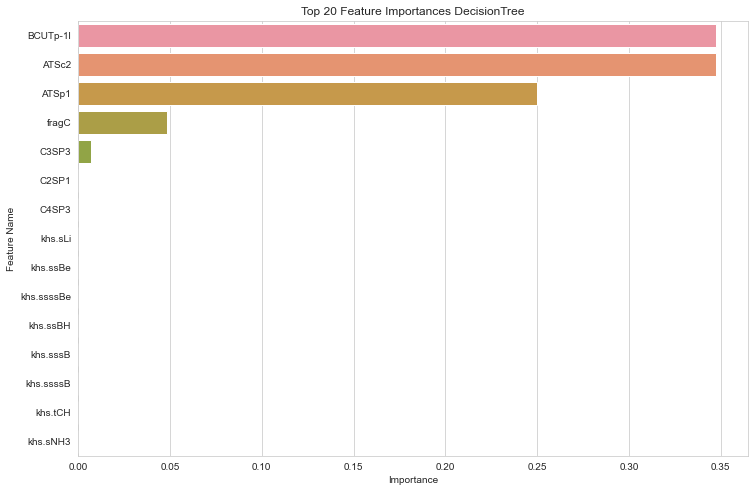

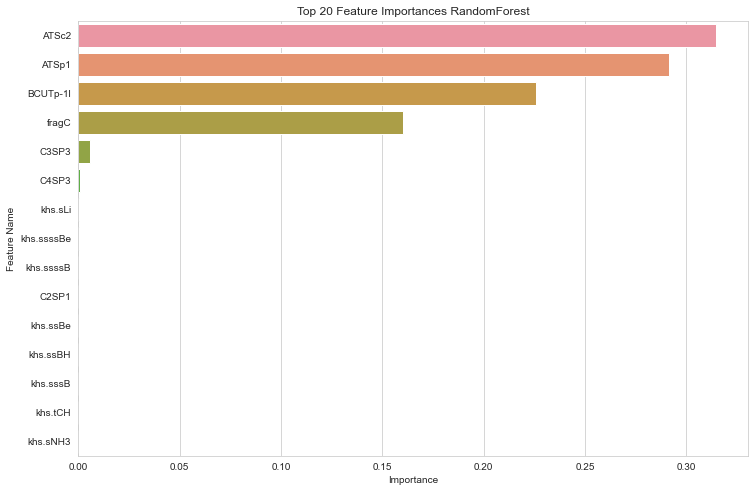

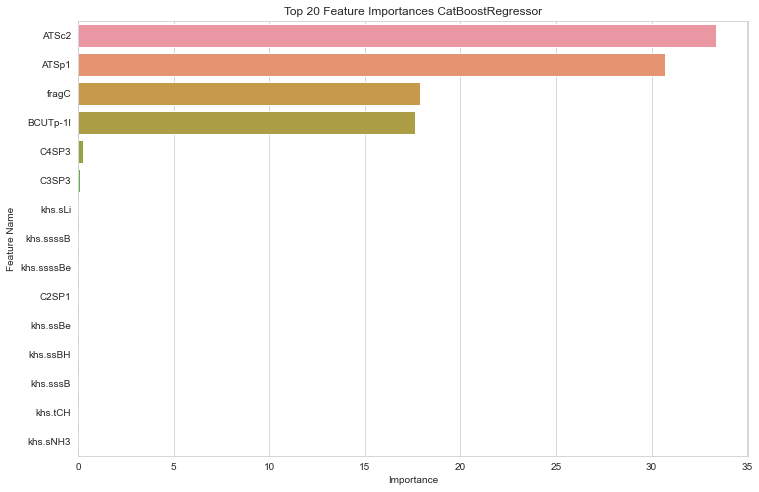

In [128]:
metric = "MAPE"

# selecting top 3 score based on metric
filtered_models_scores_df =  models_scores_df.sort_values(metric).iloc[:3, :]

for i in filtered_models_scores_df.index:
    plot_feature_importance(pipelines[i],  sfs1.k_feature_names_, ml_dict[i])

In [129]:
calc_vif(selected_features_X)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,ATSc2,2.991750
1,ATSp1,86.458059
2,BCUTp-1l,6.973056
3,C2SP1,NaN
4,C3SP3,36.300097
5,C4SP3,28.099560
6,fragC,40.347766
7,khs.sLi,inf
8,khs.ssBe,NaN
9,khs.ssssBe,inf


<a id="Feature-Selection-PCA"></a>
### 3.3 Feature Selection using PCA

In [117]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA


# initilizing and fitting the pca
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)

print("Number of Components by PCA", X_pca.shape[1])
print("Explained Variance Ratio", pca.explained_variance_ratio_.sum())

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25)

print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

Number of Components by PCA 36
Explained Variance Ratio 0.9910016806575245
Shape of X_train: (337, 36) 	 Shape of y_train: (337,)
Shape of X_test: (113, 36) 	 Shape of y_test: (113,)


In [118]:
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X.columns

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
df

,0,1
0,PC1,ATSp2
1,PC10,khs.aasN
2,PC11,C1SP1
3,PC12,khs.ssNH
4,PC13,khs.sBr
5,PC14,khs.aaS
6,PC15,khs.dsssP
7,PC16,khs.ddssS
8,PC17,khs.sCl
9,PC18,Texpi


In [119]:
# Building pipelins of standard scaler and model for varios regressors.

lasso = Lasso()

dt = DecisionTreeRegressor()

rf = RandomForestRegressor()

kn = KNeighborsRegressor()

xgb = XGBRegressor()

gbr = GradientBoostingRegressor()

eln = ElasticNet()

br = BayesianRidge()

cat = CatBoostRegressor(allow_writing_files=False, verbose=0, task_type="GPU")

lgbm = LGBMRegressor()



# List of all the pipelines
pipelines = [lasso, dt, rf, kn, xgb, gbr,
            eln, br, cat, lgbm] # 

# Dictionary of pipelines and model types for ease of reference
ml_dict = {0: "Lasso", 1: "DecisionTree", 2: "RandomForest", 3: "KNeighbors", 4: "XGBRegressor", 5: "GradientBoostingRegressor",
                6: "Elastic Net", 7:"BayesianRidge", 8: "CatBoostRegressor", 9: "LGBMRegressor"}
    #, 

models_scores_df = pd.DataFrame(columns=["model", "Mean CV", "MAE",
                                         "MAPE", "MSE", "RMSE", "R_Squared", "Adjusted_R_Squared"])



# Fit the pipelines and display the scores with Cross validation
for i, pipe in enumerate(pipelines):
    # getting the name of our model
    model_name = ml_dict[i]
    print(model_name)
    
    # fitting our data
    pipe.fit(X_train, y_train)
    
    evaluate_model(models_scores_df, i, model_name, pipe, X, y, X_test, y_test)

Lasso
all CV 5: [ 0.09596436 -0.31863139 -0.42651363  0.42078674  0.43065162]
DecisionTree


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e+00, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.813e-01, tolerance: 3.921e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [0.23188876 0.25397414 0.56960492 0.26643348 0.46352604]
RandomForest
all CV 5: [0.49195403 0.5322361  0.42270306 0.45428842 0.82258608]
KNeighbors
all CV 5: [-0.32285391  0.00632638 -0.27547185 -0.35466869 -0.30458892]
XGBRegressor
all CV 5: [0.4042212  0.55011838 0.29568576 0.46748581 0.79835454]
GradientBoostingRegressor
all CV 5: [0.50665542 0.54318946 0.54267064 0.4987885  0.77487011]
Elastic Net
all CV 5: [ 0.16256169 -0.34842207 -0.4282144   0.37582757  0.47638209]
BayesianRidge


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.873e+00, tolerance: 4.524e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.355e+01, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [-0.06315232  0.01222434  0.48846638  0.36839012 -6.24521509]
CatBoostRegressor
all CV 5: [0.50141192 0.54149301 0.32609989 0.49679384 0.78073103]
LGBMRegressor
all CV 5: [0.44795495 0.49288561 0.31319208 0.34447916 0.81183031]


In [131]:
models_scores_df

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,Lasso,0.040452,0.947539,0.396608,1.386742,1.177600,-0.029687,-0.188917
1,DecisionTree,0.353110,0.482493,0.192103,0.531647,0.729141,0.605241,0.544195
2,RandomForest,0.547946,0.480416,0.200562,0.455798,0.675128,0.661560,0.609224
3,KNeighbors,-0.250251,0.574549,0.249133,0.620731,0.787865,0.539094,0.467820
4,XGBRegressor,0.503173,0.508996,0.212513,0.548975,0.740928,0.592374,0.529339
5,GradientBoostingRegressor,0.571062,0.507216,0.216501,0.530179,0.728134,0.606331,0.545454
6,Elastic Net,0.047627,0.946948,0.396348,1.386472,1.177486,-0.029486,-0.188685
7,BayesianRidge,-1.087857,0.895605,0.373366,1.288674,1.135198,0.043131,-0.104838
8,CatBoostRegressor,0.529306,0.481341,0.203061,0.492391,0.701706,0.634389,0.577851
9,LGBMRegressor,0.482068,0.497440,0.213647,0.505608,0.711061,0.624575,0.566520


In [130]:
metric = "MAPE"

# selecting top 3 score based on metric
filtered_models_scores_df =  models_scores_df.sort_values(metric).iloc[:3, :]

for i in filtered_models_scores_df.index:
    plot_feature_importance(pipelines[i],  df[1].values, ml_dict[i])

ValueError: All arrays must be of the same length

<a id="Hyperparameter-Tuning"></a>
# 4. Hyperparameter Tuning

In [ ]:
GBR = GradientBoostingRegressor()

parameters = {'learning_rate': [0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05],
                'subsample'    : [0.9, 0.5, 0.2, 0.1],
                'n_estimators' : [100,500,1000, 1500],
                'max_depth'    : [4,6,8,10]
                }

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv=5, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.02, max_depth=10, n_estimators=500,
                          subsample=0.2)

 The best score across ALL searched params:
 0.9164469215865514

 The best parameters across ALL searched params:
 {'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.2}


In [38]:
RFR = RandomForestRegressor()

parameters = {'n_estimators' : [100,500,1000, 1500],
                'max_depth'    : [4,6,8,10],
                'criterion': ["squared_error", "absolute_error"],
                'max_features': ["auto", "sqrt", "log2"],
            }

grid_RFR = GridSearchCV(estimator=RFR, param_grid=parameters, cv=5, n_jobs=-1)
grid_RFR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_RFR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_RFR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_RFR.best_params_)


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features='sqrt')

 The best score across ALL searched params:
 0.9032530415292959

 The best parameters across ALL searched params:
 {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}


In [40]:
XGB = XGBRegressor()

parameters = {
        'min_child_weight': [1, 5, 10], #50, 100
        'gamma': [0.5, 1, 2], #1.5 5
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 6, 9], # 4, 5, 8, 10
        'learning_rate': [0.001, 0.05, 0.01, 0.15],  # 0.2 0.001
        'n_estimators': [100, 500, 500] # 300 1000
        }

grid_XGB = GridSearchCV(estimator=XGB, param_grid=parameters, cv=5, n_jobs=-1)
grid_XGB.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_XGB.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_XGB.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_XGB.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

 The best score across ALL searched params:
 0.9128726597886478

 The best parameters across ALL searched params:
 {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 500

<a id="ann"></a>
# 5. ANN

In [143]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)

In [156]:
import tensorflow as tf

model = tf.keras.Sequential([

tf.keras.layers.Dense(256, input_shape=[X.shape[1]]),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(128),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(64),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(32),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(8),
tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss="mean_absolute_error")

In [157]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 256)               57344     
                                                                 
 dropout_45 (Dropout)        (None, 256)               0         
                                                                 
 dense_74 (Dense)            (None, 128)               32896     
                                                                 
 dropout_46 (Dropout)        (None, 128)               0         
                                                                 
 dense_75 (Dense)            (None, 64)                8256      
                                                                 
 dropout_47 (Dropout)        (None, 64)                0         
                                                                 
 dense_76 (Dense)            (None, 32)              

In [158]:
history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_test, y_test), verbose=2)

Epoch 1/2000
11/11 - 1s - loss: 3.1997 - val_loss: 2.7949 - 557ms/epoch - 51ms/step
Epoch 2/2000
11/11 - 0s - loss: 3.2018 - val_loss: 2.6218 - 33ms/epoch - 3ms/step
Epoch 3/2000
11/11 - 0s - loss: 2.8918 - val_loss: 2.6010 - 33ms/epoch - 3ms/step
Epoch 4/2000
11/11 - 0s - loss: 2.8408 - val_loss: 2.4505 - 33ms/epoch - 3ms/step
Epoch 5/2000
11/11 - 0s - loss: 2.7331 - val_loss: 2.2958 - 33ms/epoch - 3ms/step
Epoch 6/2000
11/11 - 0s - loss: 2.6665 - val_loss: 2.2944 - 33ms/epoch - 3ms/step
Epoch 7/2000
11/11 - 0s - loss: 2.6737 - val_loss: 2.2648 - 34ms/epoch - 3ms/step
Epoch 8/2000
11/11 - 0s - loss: 2.4608 - val_loss: 2.1653 - 39ms/epoch - 4ms/step
Epoch 9/2000
11/11 - 0s - loss: 2.3372 - val_loss: 2.1802 - 39ms/epoch - 4ms/step
Epoch 10/2000
11/11 - 0s - loss: 2.2830 - val_loss: 2.1253 - 35ms/epoch - 3ms/step
Epoch 11/2000
11/11 - 0s - loss: 2.3659 - val_loss: 2.0643 - 34ms/epoch - 3ms/step
Epoch 12/2000
11/11 - 0s - loss: 2.3929 - val_loss: 2.0351 - 36ms/epoch - 3ms/step
Epoch 13/20

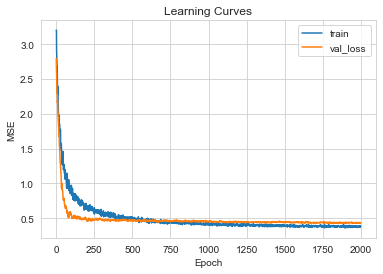

In [159]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [160]:
predictions = model.predict(X_test)

# MAE, MSE, RMSE
print("MAE: {}".format(mean_absolute_error(y_test, predictions)))
print("MSE: {}".format(mean_squared_error(y_test, predictions)))
print("RMSE: {}".format(mean_squared_error(y_test, predictions, squared=False)))
print("MAPE: {}".format(mean_absolute_percentage_error(y_test, predictions)))
print("R2: {}".format(r2_score(y_test, predictions)))

4/4 [==============================] - 0s 1ms/step
MAE: 0.43076674547870597
MSE: 0.3734092096021299
RMSE: 0.6110721803536223
MAPE: 0.18647860325900986
R2: 0.7123628885371629
